In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/TFG/

/content/drive/MyDrive/TFG


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizer_v2.adam import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
import pandas as pd


import cv2
import os

import numpy as np

In [4]:
import tarfile

tar = tarfile.open("public_images.tar.bz2", "r:bz2")  

In [5]:
def get_np_array_from_tar_object(tar_extractfl):
     '''converts a buffer from a tar file in np.array'''
     return np.asarray(
        bytearray(tar_extractfl.read())
        , dtype=np.uint8)

In [7]:
# Train data 
traindata_all = pd.read_csv('./multimodal_train.tsv', sep='\t')
# Validation data 
validata_all = pd.read_csv('./multimodal_validate.tsv', sep='\t')
# Test data 
testdata_all = pd.read_csv('./multimodal_test_public.tsv', sep='\t')

In [9]:
img_size = 224
def get_data(type, path, limit = -1):
    if type == 'train':
        source = traindata_all
    elif type == 'val':
        source  = validata_all
    elif type == 'test':
        source  = testdata_all

    data = [] 
    for index, row in source.iterrows():
        if index == limit:
            break
        try:
            img = row['id'] + '.jpg'
            class_num = row['6_way_label']
            print('[' + str(index) + ']' + ' Trying img = ' + img + ' with class = ' + str(class_num) + ' for type = ' + type)
            img_arr = cv2.imdecode(get_np_array_from_tar_object(tar.extractfile(img)), 0 )
            # img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
            resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
            data.append([resized_arr, class_num])
        except Exception as e:
           print(e)
           print('Error in row ' + str(index) + ' for image named ' + img)
    return np.array(data)

In [10]:
# Now we can easily fetch our train and validation data.
train = get_data('train', './public_image_set', 1000)
val = get_data('val', './public_image_set', 1000)

[0] Trying img = awxhir.jpg with class = 0 for type = train


KeyboardInterrupt: ignored

C:\Users\Reda\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

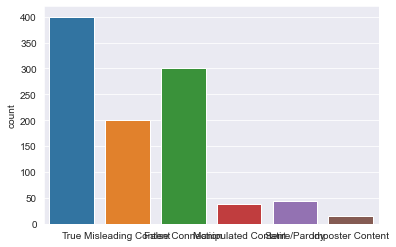

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("True")
    elif(i[1] == 1):
        l.append("Satire/Parody")
    elif(i[1] == 2):
        l.append("Misleading Content")
    elif(i[1] == 3):
        l.append("Imposter Content")
    elif(i[1] == 4):
        l.append("False Connection")
    elif(i[1] == 5):
        l.append("Manipulated Content")
sns.set_style('darkgrid')
sns.countplot(l)

Imposter content has a lower number examples so we need to balance the data 
(pendiente)

In [ ]:
def under_balance_data(data):
    
    return data

Text(0.5, 1.0, 'True')

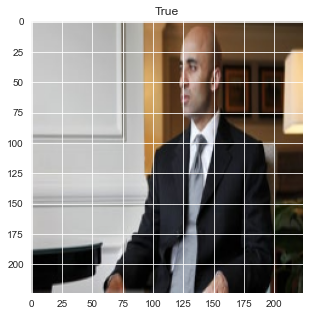

In [ ]:
labels = ['True', 'Satire/Parody', 'False Connection', 'Imposter Content' , 'Manipulated Content', 'Misleading Content']
plt.figure(figsize = (5,5))
plt.imshow(train[2][0])
plt.title(labels[train[2][1]])

Text(0.5, 1.0, 'Manipulated Content')

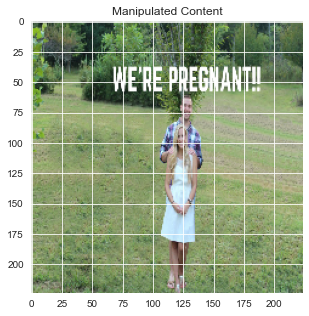

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [ ]:
opt = Adam(learning_rate=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train,y_train,epochs = 500 , validation_data = (x_val, y_val))
